From [the RLRF paper](https://arxiv.org/pdf/2505.20793)
> We preprocess this data by rounding decimals to two
significant figures, removing XML headers, and filtering out samples with excessively long URLs or
embedded base64 images, which could lead the model to memorize irrelevant content

In [27]:
import platform
import os

# Workaround for `datasets` multiprocessing crashing on macOS
fsd_var = "OBJC_DISABLE_INITIALIZE_FORK_SAFETY"
if platform.system() == "Darwin":
    print(f"Fork safety disabled: {os.environ[fsd_var]}")

Fork safety disabled: YES


In [28]:
from datasets import load_dataset, Dataset

dataset = load_dataset("starvector/svg-stack", split="train")
dataset

Dataset({
    features: ['Filename', 'Svg'],
    num_rows: 2169710
})

In [29]:
dataset[1230]

{'Filename': '0bf622d38312a560d831a6005ff2c326f7e7771d.svg',
 'Svg': '<svg role="img" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path d="M10.040 0.041 C 6.371 0.422,3.109 2.637,1.500 5.840 C 0.240 8.348,0.055 11.425,1.007 14.060 C 2.191 17.338,5.083 19.881,8.580 20.719 C 9.519 20.944,9.850 20.980,10.980 20.980 C 12.084 20.980,12.503 20.937,13.327 20.744 L 13.714 20.653 13.944 21.025 C 15.161 22.991,16.605 23.910,18.600 23.988 C 20.479 24.061,21.924 23.365,22.806 21.961 C 23.276 21.212,23.600 20.091,23.600 19.211 L 23.600 19.000 22.821 19.000 L 22.042 19.000 22.018 19.110 C 21.925 19.547,21.677 20.009,21.410 20.244 C 20.810 20.770,19.746 20.760,18.954 20.219 C 18.632 19.999,18.210 19.563,17.859 19.088 L 17.602 18.740 17.751 18.620 C 19.502 17.209,20.737 15.306,21.281 13.180 C 21.542 12.159,21.580 11.817,21.579 10.500 C 21.578 9.482,21.567 9.277,21.488 8.824 C 21.314 7.824,21.063 6.989,20.685 6.160 C 19.206 2.912,16.117 0.642,12.432 0.098 C 11.940 0.025,10.517 -0.009,10.040 

In [30]:
# Filter out any SVGs longer than 16,000 characters?
dataset_long = dataset.filter(lambda ex: len(ex["Svg"]) >= 16_000)
print(f"Number of long SVGs: {len(dataset_long)}")

Number of long SVGs: 4645


Rasterized SVG with implicit size 24.0x24.0px to image dimensions: (128, 128)


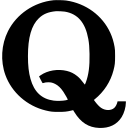

In [31]:
from PIL import Image
import os
import io
# stupid cairo
os.environ["DYLD_LIBRARY_PATH"] = "/opt/homebrew/lib:" + os.environ.get("DYLD_LIBRARY_PATH", "")

from svg_rlrf_reward import rasterize_svg

image_bytes, tree, (width, height) = rasterize_svg(dataset[1230]["Svg"], min_target=128, max_target=512)
image = Image.open(io.BytesIO(image_bytes))
print(f"Rasterized SVG with implicit size {width}x{height}px to image dimensions: {image.size}")
image

In [83]:
def rasterize(example):
    try:
        img_bytes, tree, (width, height) = rasterize_svg(example["Svg"], min_target=512, max_target=1536)
        # todo: use tree to enrich metadata
        return {"image": Image.open(io.BytesIO(img_bytes)), "width": width, "height": height}
    except Exception:
        return {"image": None, "width": None, "height": None}

subset = dataset.select(range(10000))

subset = subset.map(
    rasterize,
    # num_proc=os.cpu_count() or 4,
)

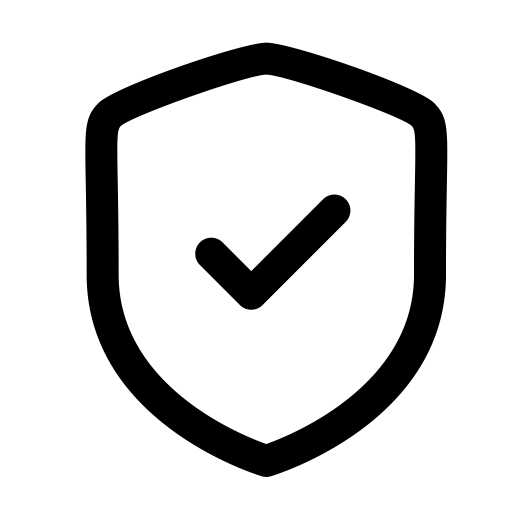

In [33]:
subset["image"][123]


In [34]:
subset = subset.filter(lambda x: x["image"] is not None)
print(f"{len(subset)}/{1000} images rendered successfully")
subset

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

7762/1000 images rendered successfully


Dataset({
    features: ['Filename', 'Svg', 'image', 'width', 'height'],
    num_rows: 7762
})

In [54]:
import re

def strip_kvg_attributes(svg_text: str) -> dict:
    # Remove all kvg: attributes (e.g. kvg:element="foo", kvg:position='bar'), even before closing tags
    # Handles cases like: <g id="kvg:07a50" kvg:element="穐">
    # Also handles attributes before self-closing tags: <path ... kvg:type="㇒"/>
    svg_text = re.sub(r'\s+kvg:[\w-]+=(["\']).*?\1(?=\s|/?>)', ' data-kvg-stripped="true"', svg_text)
    return {"Svg": svg_text}

# Apply to all SVGs in the subset
subset_stripped = subset.map(
    strip_kvg_attributes,
    input_columns="Svg",
    num_proc=os.cpu_count() or 4,
)

# Basic tests for strip_kvg_attributes
test_svg_1 = '<g id="kvg:07a50" kvg:element="穐"><path d="M10 10" kvg:type="㇒"/></g>'
expected_1 = '<g id="kvg:07a50" data-kvg-stripped="true"><path d="M10 10" data-kvg-stripped="true"/></g>'
result_1 = strip_kvg_attributes(test_svg_1)["Svg"]
assert result_1 == expected_1, f"Test 1 failed: {result_1} != {expected_1}"

test_svg_2 = '<svg xmlns="http://www.w3.org/2000/svg" kvg:foo="bar" width="100"><g kvg:element="x" kvg:position="y"></g></svg>'
expected_2 = '<svg xmlns="http://www.w3.org/2000/svg" data-kvg-stripped="true" width="100"><g data-kvg-stripped="true" data-kvg-stripped="true"></g></svg>'
result_2 = strip_kvg_attributes(test_svg_2)["Svg"]
assert result_2 == expected_2, f"Test 2 failed: {result_2} != {expected_2}"

test_svg_3 = '<path d="M0 0" kvg:type="㇒" kvg:element="foo" fill="none"/>'
expected_3 = '<path d="M0 0" data-kvg-stripped="true" data-kvg-stripped="true" fill="none"/>'
result_3 = strip_kvg_attributes(test_svg_3)["Svg"]
assert result_3 == expected_3, f"Test 3 failed: {result_3} != {expected_3}"

test_svg_4 = '<g><path d="M0 0" /></g>'
expected_4 = '<g><path d="M0 0" /></g>'
result_4 = strip_kvg_attributes(test_svg_4)["Svg"]
assert result_4 == expected_4, f"Test 4 failed: {result_4} != {expected_4}"


for i, (orig, stripped) in enumerate(zip(subset["Svg"], subset_stripped["Svg"])):
    if orig != stripped:
        print(f"SVG {i} differs after stripping kvg attributes:\n{stripped}")

SVG 1206 differs after stripping kvg attributes:
<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="109" height="109" viewBox="0 0 109 109" xlink:used="" data-num-strokes="6">
  <style id="style-Kanimaji">
/* CSS automatically generated by kanimaji.py, do not edit! */

.backward {
    animation-direction: reverse !important;
}

#kvg\3a StrokePaths_05978 {
    stroke-width: 4.5px !important;
    stroke:       #666 !important;
}

/* stroke kvg:05978-s1 */
#kvg\3a 05978-s1-brush, #kvg\3a 05978-s1-brush-brd, #kvg\3a 05978-s1-bg {
    visibility: hidden;
}
[class *= "current"] ~ #kvg\3a 05978-s1-anim {
    visibility: hidden;
}
[class *= "current"] ~ #kvg\3a 05978-s1-bg, #kvg\3a 05978-s1-bg.animate {
    visibility: visible;
}
@keyframes strike-05978-s1 {
    0% { stroke-dashoffset: 79.852; }
    100% { stroke-dashoffset: 0; }
}
#kvg\3a 05978-s1-anim.animate {
    stroke: #f00;
    stroke-dasharray: 79.852 79.852;
    visibility: visible;
    animation

In [55]:
# A number of SVGs are cut off in the dataset. We should filter them.
def has_balanced_svg_tags(svg_text: str):
    open_tags = len(re.findall(r"<svg\b[^>]*>", svg_text, flags=re.IGNORECASE))
    close_tags = len(re.findall(r"</svg\s*>", svg_text, flags=re.IGNORECASE))
    if open_tags == 0 or close_tags == 0:
        return False
    if open_tags != close_tags:
        return False
    return True

print("Should be true:", has_balanced_svg_tags("<svg><path d='M10 10'/>\n<svg>blah</svg>\n</svg>"))
print("Should be false:", has_balanced_svg_tags("<svg>\n<path d='M10 10'/>\n<svg>blah</svg>"))

subset = subset.filter(has_balanced_svg_tags, input_columns=["Svg"])
print(f"{len(subset)} images after filtering for balanced <svg> tags")



Should be true: True
Should be false: False


Filter:   0%|          | 0/7762 [00:00<?, ? examples/s]

7762 images after filtering for balanced <svg> tags


In [56]:
import subprocess
import tempfile
import os
from pathlib import Path

from datasets import Value, Features

def svgo_single(input_path, output_path, svgo_args, svgo_version: str = "latest") -> tuple[str, None] | tuple[None, str]:
    """Returns either the optimized SVG or the error message from svgo."""
    single_cmd = [
        "npx",
        "-y",
        f"svgo@{svgo_version}",
        "-i",
        input_path,
        "-o",
        output_path,
        *svgo_args,
    ]
    proc = subprocess.run(
        single_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE
    )
    if proc.returncode != 0 or not os.path.exists(output_path):
        return None, proc.stderr.decode('utf-8')
    else:
        with open(output_path, "r", encoding="utf-8") as f:
            return f.read(), None

# Latest version of svgo fails on some files, so we use an older version
def svgo_batch(
    svg_texts,
    names: list[str] | None = None,
    precision: int = 2,
    pretty: bool = False,
    svgo_version: str = "3.1.0",
    retry_with_latest: bool = True,
    write_failures_to: Path | None = None,
) -> tuple[list[str], list[str]]:
    """
    Optimize a batch of SVGs by writing them to a temp directory and running svgo on the directory.
    Returns a list of optimized SVG strings in the same order.
    If the batch fails, runs on individual files so that only the bad files are excluded.
    Uses the same input/output directories for individual files.
    """
    def filename(i: int) -> str:
        if names is None:
            return f"{i:06d}.svg"
        else:
            return names[i]

    if write_failures_to is not None:
        write_failures_to = Path(write_failures_to)
        write_failures_to.mkdir(parents=True, exist_ok=True)

    svgo_args = ["--precision", str(precision)]
    if pretty:
        svgo_args.append("--pretty")

    with tempfile.TemporaryDirectory() as tmpdir:
        input_dir = os.path.join(tmpdir, "input")
        output_dir = os.path.join(tmpdir, "output")
        os.makedirs(input_dir, exist_ok=True)
        os.makedirs(output_dir, exist_ok=True)
        # Write each SVG to a file in the input directory
        for i, svg in enumerate(svg_texts):
            fname = filename(i)
            with open(os.path.join(input_dir, fname), "w", encoding="utf-8") as f:
                f.write(svg)
        # Run svgo on the directory

        cmd = [
            "npx", "-y", f"svgo@{svgo_version}",
            "-f", input_dir,
            "-o", output_dir,
            *svgo_args,
        ]
        proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        optimized_svgs = []
        errors = []
        batch_failed = proc.returncode != 0
        if batch_failed:
            print(f"SVGO on {[filename(i) for i in range(len(svg_texts))]} failed, retrying with individual files.")
            # Try to optimize each SVG individually, reusing the same input/output dirs
            for i, svg in enumerate(svg_texts):
                fname = filename(i)
                input_path = os.path.join(input_dir, fname)
                output_path = os.path.join(output_dir, fname)

                optimized_svg, error = svgo_single(input_path, output_path, svgo_args, svgo_version)

                if optimized_svg is None:
                    if write_failures_to is not None:
                        with open(write_failures_to / fname, "w", encoding="utf-8") as f:
                            f.write(svg)
                        with open(write_failures_to / f"{fname}_error.txt", "w", encoding="utf-8") as f:
                            f.write(error)
                    else:
                        print(f"SVGO failed on {input_path}")
                        print(error)

                    if retry_with_latest:
                        # Try again with latest version of svgo
                        optimized_svg, error = svgo_single(
                            input_path, output_path, svgo_args, svgo_version="latest"
                        )
                        if optimized_svg is not None:
                            print(f"SVGO fixed {input_path} on latest version.")
                    
                # If svgo failed to write output, exclude the file from the dataset (write None to the list)
                optimized_svgs.append(optimized_svg)
                errors.append(error)
        else:
            # Read optimized SVGs in the same order using out_fnames
            for i in range(len(svg_texts)):
                out_path = os.path.join(output_dir, filename(i))
                if not os.path.exists(out_path):
                    print(f"SVGO failed on {out_path}")
                    # If svgo failed to write output, fallback to original
                    optimized_svgs.append(None)
                    errors.append("File not found")
                else:
                    with open(out_path, "r", encoding="utf-8") as f:
                        optimized_svgs.append(f.read())
                        errors.append(None)
        return optimized_svgs, errors

original_svg = dataset[1230]["Svg"]
optimized_svg = svgo_batch([original_svg])[0][0]
print(f"Saved {len(original_svg) - len(optimized_svg)} bytes ({((len(original_svg) - len(optimized_svg)) / len(original_svg) * 100):.2f}%) by optimizing")

failures_dir = Path("svgo_failures")

def svg_optim_batched(batch, **kwargs):
    optimized_svgs, errors = svgo_batch(batch["Svg"], batch["Filename"], write_failures_to=failures_dir, **kwargs)
    metas = []
    for original_svg, optimized_svg, error in zip(batch["Svg"], optimized_svgs, errors):
        if optimized_svg is None:
            metas.append({
                "original_size": len(original_svg),
                "optimized_size": -1,
                "bytes_saved": -1,
                "saved_ratio": -1,
                "svgo_error": error
            })
        else:
            metas.append({
                "original_size": len(original_svg),
                "optimized_size": len(optimized_svg),
                "bytes_saved": len(original_svg) - len(optimized_svg),
                "saved_ratio": ((len(original_svg) - len(optimized_svg)) / len(original_svg)),
                "svgo_error": None
            })
    return {"Svg": optimized_svgs, "meta": metas}

features: Features = subset.features.copy()
features["meta"] = {
    "original_size": Value("int32"),
    "optimized_size": Value("int32"),
    "bytes_saved": Value("int32"),
    "saved_ratio": Value("float32"),
    "svgo_error": Value("string"),
}

# Use batch mapping for speed, now using file-based batch optimization
subset_opt = subset.map(
    svg_optim_batched,
    batched=True,
    batch_size=32,
    features=features,
    num_proc=16,
)
subset_opt


# Print some examples that failed optimization (i.e., svgo_error is not None)
failed_examples = [ex for ex in subset_opt if ex.get("meta", {}).get("svgo_error") not in (None, "", "None")]
print(f"{len(failed_examples)}/{len(subset_opt)} examples failed optimization")
for ex in failed_examples[:5]:
    print("-" * 100, "\n", ex.get('Filename', 'N/A'), "\n", ex.get('Svg', ''), "\n")


Saved 916 bytes (48.59%) by optimizing


Map (num_proc=16):   0%|          | 0/7762 [00:00<?, ? examples/s]

0/7762 examples failed optimization


In [57]:
subset_opt[0]["meta"]

{'original_size': 1165,
 'optimized_size': 408,
 'bytes_saved': 757,
 'saved_ratio': 0.6497853994369507,
 'svgo_error': None}

Filter:   0%|          | 0/7762 [00:00<?, ? examples/s]

7711/7762 images are free of base64 images
Examples with base64 images (showing up to 5):
---------------------------------------------------------------------------------------------------- 
 eeb61ae6c3e61554d6b2808412dff90704f4ca10.svg 
 <svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="103" height="69.03"><defs><filter id="a" width="56.03" height="36.5" x="401.97" y="409.97" filterUnits="userSpaceOnUse"><feImage xlink:href="" width="56.03" height="36.5" x="401.97" y="409.97" preserveAspectRatio="none" result="image"/><feComposite in2="SourceGraphic" operator="in" result="composite"/><feBlend in2="SourceGraphic" mode="overlay" result="blend"/></filter><filter id="b" width="92" height="68" x="355" y="411" filterUnits="userSpaceOnUse"><feOffset dy="5" in="SourceAlpha" result="offset"/><feGaussianBlur result="blur" stdDeviation="3.16"/><feFlood flood-opacity=".15" result="flood"/><feComposite in2="blur" operator="in" result="composite"/><feBlend i
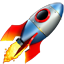
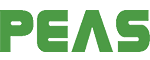
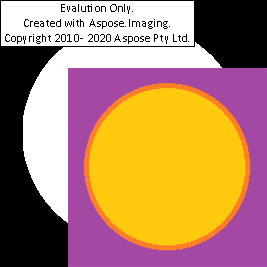

In [64]:
def no_base64_image(svg_text):
    # Look for <image ... xlink:href="data:image/..." or href="data:image/..."
    return not re.search(r'(xlink:href|href)\s*=\s*["\']data:image\/', svg_text)

subset_no_base64 = subset_opt.filter(no_base64_image, input_columns="Svg")
subset_no_base64

print(f"{len(subset_no_base64)}/{len(subset_opt)} images are free of base64 images")

# Print some examples that fail the check
failed_examples = [ex for ex in subset_opt if not no_base64_image(ex["Svg"])]
print("Examples with base64 images (showing up to 5):")
for ex in failed_examples[:5]:
    print("-"*100, "\n", ex.get('Filename', 'N/A'), "\n", ex.get('Svg', ''), "\n")

In [60]:
# filter out any images that are a solid color
def not_solid_color(image: Image.Image):
    assert image.mode == "RGB", "Image must be RGB"
    extrema = image.getextrema()
    return any(lo != hi for lo, hi in extrema)

subset_not_solid_color = subset_opt.filter(not_solid_color, input_columns=["image"])
subset_not_solid_color

# Print some examples that fail the check
failed_examples = [ex for ex in subset_opt if not not_solid_color(ex["image"])]
print(f"{len(failed_examples)}/{len(subset_opt)} images were solid-color")
for ex in failed_examples:
    print("-"*100, "\n", ex.get('Filename', 'N/A'), "\n", ex.get('Svg', ''), "\n")


7/7762 images were solid-color
---------------------------------------------------------------------------------------------------- 
 bf5f2150bee886e40c528f244cdbd7e481a07b70.svg 
 <svg xmlns="http://www.w3.org/2000/svg" width="400" height="400" preserveAspectRatio="xMinYMin slice"><path fill="red" d="M0 400V0h400v400Z"/></svg> 

---------------------------------------------------------------------------------------------------- 
 26e2d59b2e1fbbe1f802dbeee6c256ac4e2a9225.svg 
 <svg xmlns="http://www.w3.org/2000/svg" stroke-linecap="round" stroke-linejoin="round" stroke-width="2" viewBox="0 0 24 24"><path d="M0 0h24v24H0z"/><path d="M17 18.5a6 6 0 0 1-5 0 6 6 0 0 0-5 .5 3 3 0 0 0 2-2.5V9a4 4 0 0 1 7.45-2m-2.55 6h-7"/></svg> 

---------------------------------------------------------------------------------------------------- 
 faaadaf352debe7587bc968975b2667a9d784991.svg 
 <svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="72" height="72"><use xlin

In [76]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", fast=True)

def add_token_counts(ex: dict[str, list[any]]):
    svgs_tokenized = tokenizer(ex["Svg"], padding=False, truncation=False)["input_ids"]
    return {"svg_token_count": [len(t) for t in svgs_tokenized]}

subset_opt_tk = subset_opt.map(add_token_counts, batched=True, batch_size=256)

min_tokens = 100
subset_gt_thresh = subset_opt_tk.filter(lambda ex: ex["svg_token_count"] >= min_tokens)
subset_gt_thresh

# Print some examples that failed the check
failed = subset_opt_tk.filter(lambda ex: ex["svg_token_count"] <= min_tokens)
print(f"{len(failed)}/{len(subset_opt_tk)} examples have less than {min_tokens} tokens")
for ex in failed:
    print("-" * 100, "\n", f"{ex['Filename']}: {ex['svg_token_count']} tokens\n", ex.get("Svg", ""), "\n")


210/7762 examples have less than 100 tokens
---------------------------------------------------------------------------------------------------- 
 32c49e5595f87ef49f2c17d89b56541a6308ad22.svg: 77 tokens
 <svg xmlns="http://www.w3.org/2000/svg" fill="currentColor" viewBox="0 0 32 32"><path d="M9 18h16a1 1 0 0 0 0-2H9a1 1 0 0 0 0 2"/></svg> 

---------------------------------------------------------------------------------------------------- 
 98b70477c601d03a0ec1783a79a3e942bc335397.svg: 98 tokens
 <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 32 32"><path d="M2 4h4V2a2 2 0 0 1 4 0v2h12V2a2 2 0 0 1 4 0v2h4v6H2m0 2h28v18H2"/></svg> 

---------------------------------------------------------------------------------------------------- 
 e6057caf6636630707582c49133e67d54de96241.svg: 65 tokens
 <svg xmlns="http://www.w3.org/2000/svg" width="100" height="80"><text x="50" y="40" style="font-size:76px;dominant-baseline:central;text-anchor:middle">悲</text></svg> 

------------------------

Filter:   0%|          | 0/7762 [00:00<?, ? examples/s]

407/7557 examples contain <text> elements
---------------------------------------------------------------------------------------------------- 
 26256bdf7e3e71a02c7ced60963f2d2b1cab56e4.svg
 <svg xmlns="http://www.w3.org/2000/svg" width="420" height="320"><defs><clipPath id="a"><path d="M5.5 135.5h410v178H5.5zm402 10v158h-394v-158zm2-2h-398v162h398z"/></clipPath><clipPath id="c"><path d="M4.5 3.5h410v78H4.5zm402 10v58h-394v-58zm2-2h-398v62h398z"/></clipPath><filter id="b"><feGaussianBlur in="SourceAlpha" stdDeviation="2.5"/><feOffset dy="2" result="offsetblur"/><feFlood flood-color="#000"/><feComposite in2="offsetblur" operator="in"/></filter><filter id="d"><feGaussianBlur in="SourceAlpha" stdDeviation="2.5"/><feOffset dy="2" result="offsetblur"/><feFlood flood-color="#000"/><feComposite in2="offsetblur" operator="in"/></filter></defs><path fill="rgba(0,0,0,0.75)" d="M409.5 143.5v162h-398v-162zm-2 2h-394v158h394z" clip-path="url(#a)" filter="url(#b)"/><path fill="none" stroke="#000" st
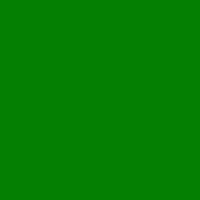
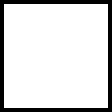

In [66]:
def no_text(svg_text: str):
    return not re.search(r'<text', svg_text)

subset_no_text = subset_opt.filter(no_text, input_columns="Svg")
subset_no_text

# Print some examples that failed the check
failed_text = subset_opt.filter(lambda ex: re.search(r"<text", ex["Svg"]))
print(f"{len(failed_text)}/{len(subset_gt_thresh)} examples contain <text> elements")
for ex in failed_text:
    print("-" * 100, "\n", f"{ex['Filename']}\n", ex.get("Svg", ""), "\n")

In [85]:
# Run all filters in sequence

def run_all_processing(subset: Dataset, min_tokens: int = 100):
    num_proc = os.cpu_count() or 4
    # 1. Remove solid-color images
    filtered = (
        subset.filter(lambda ex: len(ex["Svg"]) < 16_000, desc="len() < 16k chars")
        .filter(
            has_balanced_svg_tags,
            input_columns="Svg",
            num_proc=num_proc,
            desc="Balanced <svg> vs </svg>",
        )
        .filter(
            no_base64_image,
            input_columns="Svg",
            num_proc=num_proc,
            desc="Filtering base64 images",
        )
        .filter(
            no_text,
            input_columns="Svg",
            num_proc=num_proc,
            desc="Filtering <text> elements",
        )
        .map(rasterize, num_proc=num_proc, desc="Rasterizing")
        .filter(
            lambda im: im is not None,
            input_columns="image",
            desc="Filtering Empty Images",
            batch_size=512,
            num_proc=num_proc,
        )
        .filter(
            not_solid_color,
            input_columns="image",
            num_proc=num_proc,
            desc="Not Solid Color",
        )
        .filter(
            strip_kvg_attributes,
            input_columns="Svg",
            num_proc=num_proc,
            desc="Filtering kvg:*",
        )
        .map(
            svg_optim_batched,
            batched=True,
            batch_size=32,
            features=features,
            num_proc=num_proc,
            desc="Optimizing",
        )
        .filter(lambda svg: svg is not None, input_columns="Svg", num_proc=num_proc,
            desc="Filtering Unoptimizable SVGs",
        )
        .map(add_token_counts, batched=True, batch_size=256, num_proc=num_proc, desc="Tokenizing")
        .filter(
            lambda count: count >= min_tokens,
            input_columns="svg_token_count",
            num_proc=num_proc,
            desc="Token Count",
        )
    )
    return filtered

# split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
# train_dataset = split_dataset["train"]
# test_dataset = split_dataset["test"]



print("Building train dataset")
train = run_all_processing(dataset.select(range(100_000)))

print("Building test dataset")
test = run_all_processing(dataset.select(range(100_000, 100_000 + 10_000)))

print("Building val dataset")
dataset_val = load_dataset("starvector/svg-stack", split="val")
val = run_all_processing(dataset_val.select(range(10_000)))
print("Done")

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
train, val, test

Building train dataset
Building test dataset
Building val dataset


len() < 16k chars:   0%|          | 0/10000 [00:00<?, ? examples/s]

Balanced <svg> vs </svg> (num_proc=8):   0%|          | 0/9979 [00:00<?, ? examples/s]

Filtering base64 images (num_proc=8):   0%|          | 0/9930 [00:00<?, ? examples/s]

Filtering <text> elements (num_proc=8):   0%|          | 0/9836 [00:00<?, ? examples/s]

Rasterizing (num_proc=8):   0%|          | 0/9048 [00:00<?, ? examples/s]

Filtering Empty Images (num_proc=8):   0%|          | 0/9048 [00:00<?, ? examples/s]

Not Solid Color (num_proc=8):   0%|          | 0/7295 [00:00<?, ? examples/s]

Filtering kvg:* (num_proc=8):   0%|          | 0/7288 [00:00<?, ? examples/s]

Optimizing (num_proc=8):   0%|          | 0/7288 [00:00<?, ? examples/s]

SVGO on ['25e70368f0975af423844a144b17075797b3ce31.svg', 'e89b3f201869beb73888fac64c38dcef008fc517.svg', '8e16bcdc1b72b31680b86c6324a43364e8f4f8fe.svg', '0741430240657822cb52c44330f747628c4d59d1.svg', '4e7fec94e6bded7a06f27786915f58984aa71bf7.svg', 'f954949e3e653383db578cf29de6d64682ae1e2b.svg', '8f07477f079a7110ed024614f16c04a672a3a65a.svg', 'd3286857d6b9533865f6818790d704a2fd2b6b7d.svg', '30e710dad4b7067d62f9714bc0b60d0b8b2be664.svg', '78212803df2ace4916907d5320c9c96a29101db4.svg', '8f9c73eb2aa6f0987d93128ddbc4ceea4c90f09b.svg', '2cc6ef45f1cddc00acac80cd2f3b4cd950ccc457.svg', '7a338a4da4ba016ebdab8da66072314e0e242fb6.svg', 'c01572841d7fe40653a16664373481fbc5256c92.svg', 'd4c59515f749869190f36a76bd0186c882318da3.svg', 'b2c83d27e3ff7d6c3a2b424eec41d371ba9e4de3.svg', '3108dfe1ffe432957e3f3c81ee9f70c230ef77d4.svg', 'fd620ff107787e70c34ebaab22db0b998287af33.svg', '041373fbea2eb59e8e0d07e471c4b439bd6437ce.svg', '195ae889ae121939859f71e6bc960d97e2ed5c71.svg', '9690a29188b253767654934a2f6bc7

Filtering Unoptimizable SVGs (num_proc=8):   0%|          | 0/7288 [00:00<?, ? examples/s]

Tokenizing (num_proc=8):   0%|          | 0/7286 [00:00<?, ? examples/s]

Token Count (num_proc=8):   0%|          | 0/7286 [00:00<?, ? examples/s]

Done
Train: 70513, Val: 7109, Test: 7030


(Dataset({
     features: ['Filename', 'Svg', 'image', 'width', 'height', 'meta', 'svg_token_count'],
     num_rows: 70513
 }),
 Dataset({
     features: ['Filename', 'Svg', 'image', 'width', 'height', 'meta', 'svg_token_count'],
     num_rows: 7109
 }),
 Dataset({
     features: ['Filename', 'Svg', 'image', 'width', 'height', 'meta', 'svg_token_count'],
     num_rows: 7030
 }))

In [86]:
from datasets import DatasetDict

# Merge train and val datasets
dataset_final = DatasetDict({"train": train, "val": val, "test": test})
# Push to the Hugging Face Hub (private)
dataset_final.push_to_hub("darknoon/svg-stack-filtered")


Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/23505 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/236 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/439M [00:00<?, ?B/s]

Map:   0%|          | 0/23504 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/236 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/430M [00:00<?, ?B/s]

Map:   0%|          | 0/23504 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/236 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/436M [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/7109 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/72 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/131M [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/7030 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/71 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/131M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/688 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/darknoon/svg-stack-filtered/commit/8503a6e512ca2c646a9bb5e7a99fdc5c690c9ea4', commit_message='Upload dataset', commit_description='', oid='8503a6e512ca2c646a9bb5e7a99fdc5c690c9ea4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/darknoon/svg-stack-filtered', endpoint='https://huggingface.co', repo_type='dataset', repo_id='darknoon/svg-stack-filtered'), pr_revision=None, pr_num=None)